# Applied Machine Learning 2024: *Initial Project*
#### *Niels August Daivdsen (phx657)*
___

## First part: Classifying electrions from 25 parameters

In [25]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# BDT packages
import xgboost as xgb
import lightgbm as lgb


In [26]:
### Set default plot parameters

# Font and fontsize
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# Grid
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['grid.color'] = 'white'
plt.rcParams['axes.grid'] = True

# Background color
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'gainsboro'
plt.rcParams['savefig.facecolor'] = 'white'

# Legend background color
plt.rcParams['legend.facecolor'] = 'white'


In [27]:
# Loading the training data
train_data = pd.read_csv("AppML_InitialProject_train.csv", sep=",")
input_data = train_data.drop(columns=['p_Truth_isElectron', 'p_Truth_Energy'])
truth_data = train_data['p_Truth_isElectron']                                   # Chech only if it is an electron
variables = input_data.columns.tolist()                                         # List of variables used in the model


# Loading the test data (for applying the model)
test_data = pd.read_csv("AppMl_InitialProject_test_classification.csv", sep=",")


# Splitting the training data using sklearn
from sklearn.model_selection import train_test_split
X_train, x_valid, Y_train, y_valid = train_test_split(input_data, truth_data, test_size=0.2, random_state=42)

print(f"Ratio of electons in training data: {Y_train.sum()/len(Y_train):.2f} ({Y_train.sum()} electrons)")

Ratio of electons in training data: 0.21 (30326 electrons)


### Deciding the most important parameters - Using Permutation Importance and SHAP-values

In [28]:
# Permutation importance
from sklearn.inspection import permutation_importance

model = lgb.LGBMClassifier(
    boosting_type="gbdt",
    objective="binary",
    metric="binary_logloss",
    num_leaves=10,
    verbose=0,
    n_estimators=100,
    early_stopping_rounds=20
)

# Fitting the model
model.fit(X_train, Y_train, eval_set=[(x_valid, y_valid)])

# Calculating the permutation importance
# perm_importance = permutation_importance(model, 
#     x_valid,
#     y_valid, 
#     n_repeats=10,
#     random_state=42
# )
# 
# sorted_idx = perm_importance.importances_mean.argsort()
# sort_variables = np.array(variables)[sorted_idx]
# 
# # Write sort_variables to a file
# with open("sort_variables.txt", "w") as f:
#     for var in sort_variables:
#         f.write(f"{var}\n")
#     # close the file
#     f.close()


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20


LGBMClassifier(early_stopping_rounds=20, metric='binary_logloss', num_leaves=10,
               objective='binary', verbose=0)

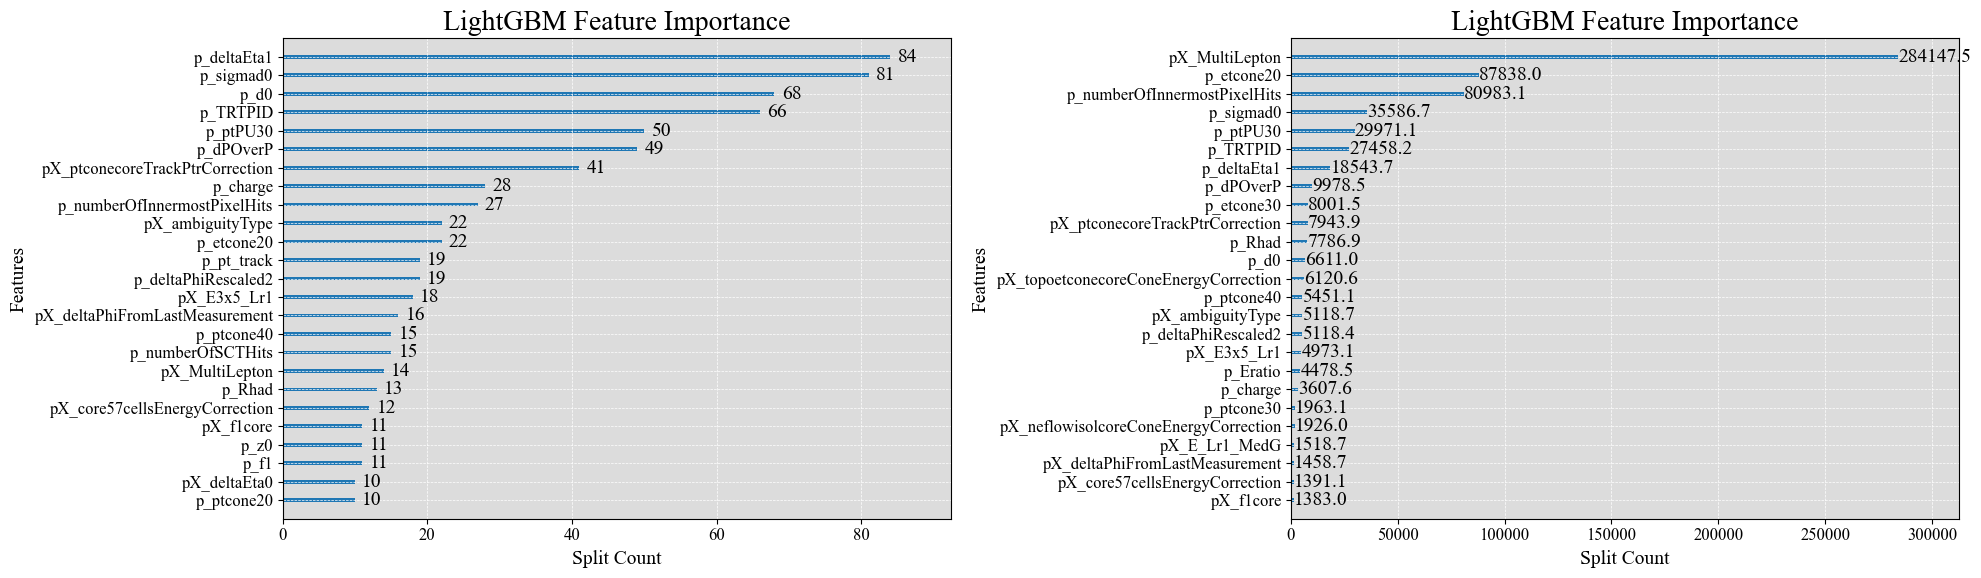

In [29]:
# LightGBM feature importance

fig, ax = plt.subplots(1,2,figsize=(20, 6))

lgb.plot_importance(
    model,
    max_num_features=25,
    importance_type="split",
    title="LightGBM Feature Importance",
    ax=ax[0],
    xlabel="Split Count",
    ylabel="Features",
    figsize=(10, 6),
    precision=1,
)
lgb.plot_importance(
    model,
    max_num_features=25,
    importance_type="gain",
    title="LightGBM Feature Importance",
    xlabel="Split Count",
    ax=ax[1],
    ylabel="Features",
    figsize=(10, 6),
    precision=1

)

plt.tight_layout()

In [30]:
#fig, ax = plt.subplots(figsize=(20, 15))
#top_25_vars = sort_variables[-25:]
#low_25_vars = sort_variables[:25]
#
#ax.barh(top_25_vars, 
#        perm_importance.importances_mean[sorted_idx][-25:], 
#        xerr=perm_importance.importances_std[sorted_idx][-25:], 
#        align="center", 
#        color="C0", 
#        alpha=0.7,
#)
#
#
#ax.set_xlabel("Permutation Importance (mean ± std)")
#ax.set_title("Permutation Importance of Features")
#fig.tight_layout()
#
#plt.savefig("figures/Permutation_Importance.png", dpi=250)

/Users/nielsaugustdavidsen/Documents/GitHub/AppliedML2025_fork/appmlenv/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


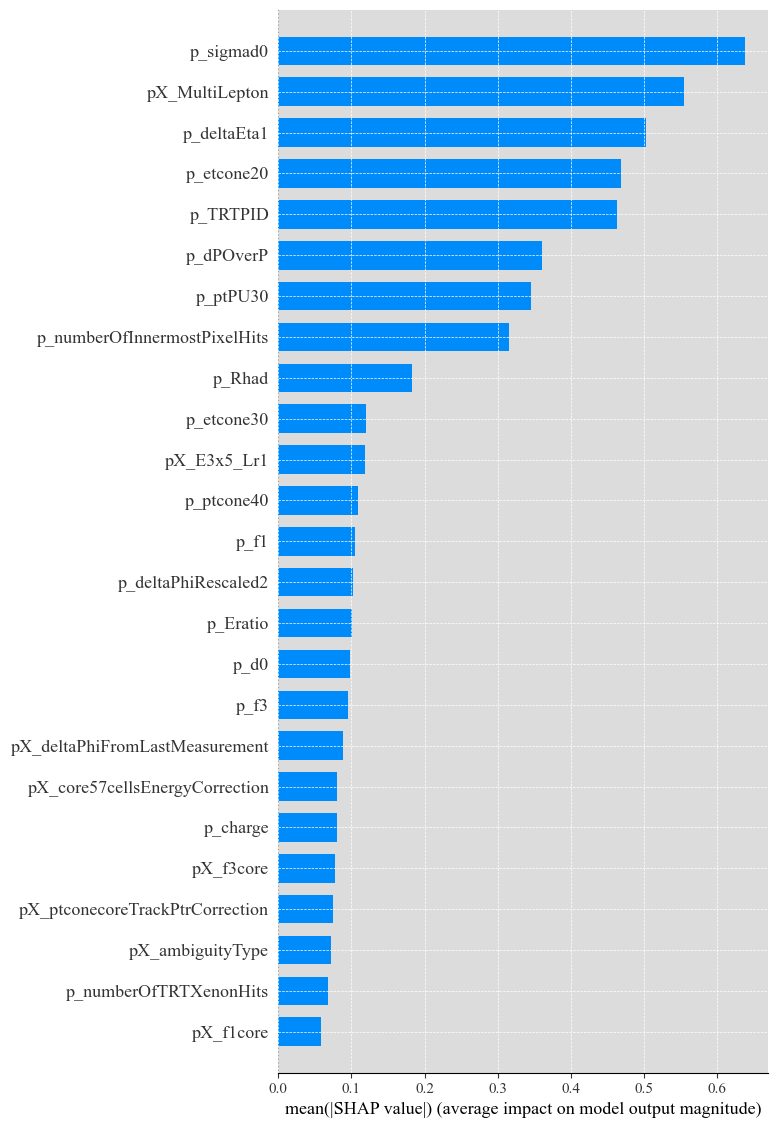

In [31]:
# Read the sorted variables from the file
with open("sort_variables.txt", "r") as f:
    sort_variables = [line.strip() for line in f.readlines()]
    # close the file
    f.close()

# SHAP values 
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(input_data)
shap.summary_plot(shap_values, 
                   input_data, 
                   feature_names=variables, 
                   max_display=25, 
                   plot_type="bar", 
                   color_bar=True,
)



### Boosted desicion trees (BDT) using LGBM

In [32]:
def quick_lbg_bdt(input_data, truth_data, model_params, nbr=1000, esr=20):
    """
    Function to quickly train a LightGBM BDT classifier and return the model and the predictions.
    """
    # Splitting the training data using sklearn
    from sklearn.model_selection import train_test_split
    X_train, x_valid, Y_train, y_valid = train_test_split(input_data, truth_data, test_size=0.2, random_state=42)

    lbg_train = lgb.Dataset(X_train, label=Y_train)
    lbg_test = lgb.Dataset(x_valid, label=y_valid)

    # Training the model
    model = lgb.train(
        model_params,
        train_set=lbg_train,
        valid_sets=lbg_test,
        num_boost_round=nbr,
        callbacks=[lgb.early_stopping(esr, verbose=True)],
    )

    # Getting the predictions
    y_pred = model.predict(x_valid, num_iteration=model.best_iteration)
    binary_score = np.where(y_pred > 0.5, 1, 0)
    
    return model, y_pred, binary_score

In [33]:
# Reshaping data according to the top 25 variables
reshap_data = input_data[sort_variables[-25:]].copy()


# Splitting the reshaped data into training and test sets
X_train, X_valid, y_train, y_valid = train_test_split(reshap_data, truth_data, test_size=0.2, random_state=42)

params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "boosting_type": "gbdt",
    "num_leaves": 30,
    "verbose": 0,
    "learning_rate": 0.1
}

model, y_score, binary_score = quick_lbg_bdt(
    reshap_data,
    truth_data,
    model_params=params,
    nbr=1000,
    esr=20
)

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[317]	valid_0's binary_logloss: 0.0667137


Text(0.5, 1.0, 'ROC curve for LightGBM Classifier (BDT) used on top 25 variables')

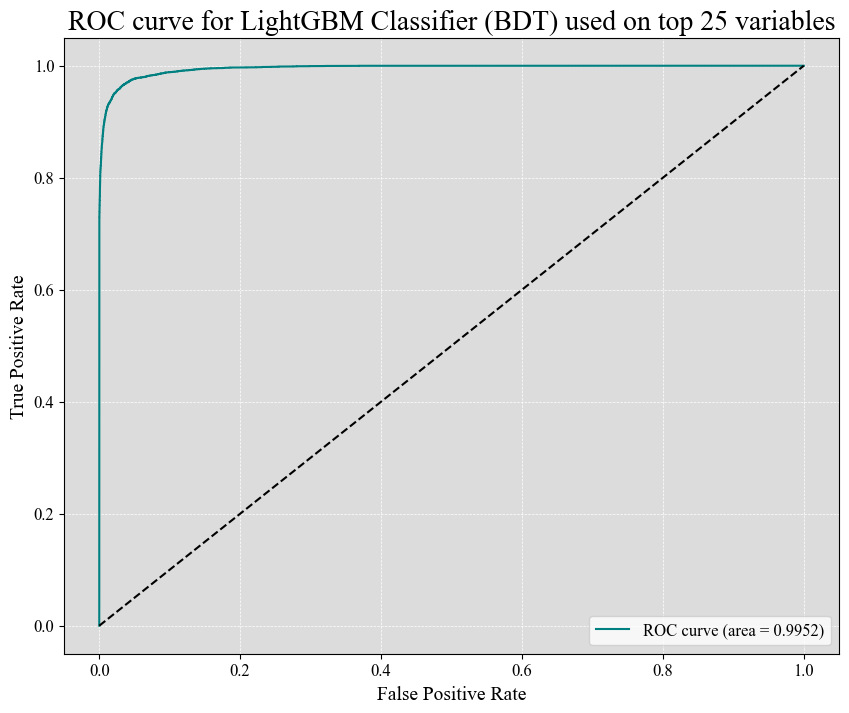

In [34]:
# Evaluating the model
from sklearn.metrics import roc_curve, auc, roc_auc_score

fpr, tpr, _ = roc_curve(y_valid, y_score)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(fpr, tpr, color="teal", label=f"ROC curve (area = {roc_auc:.4f})")
ax.plot([0, 1], [0, 1], color="k", linestyle="--")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(loc="lower right")
ax.set_title("ROC curve for LightGBM Classifier (BDT) used on top 25 variables")

In [35]:
# Checking for overfitting

train_pred = model.predict(X_train)
train_auc = roc_auc_score(y_train, train_pred)

valid_pred = model.predict(X_valid)
valid_auc = roc_auc_score(y_valid, valid_pred)
print(f"Train AUC: {train_auc:.4f}")
print(f"Validation AUC: {valid_auc:.4f}")



Train AUC: 0.9992
Validation AUC: 0.9952


### Hyper Parameter optimization using Optuna (scrapped)

In [36]:
import optuna
from sklearn.metrics import mean_squared_error, roc_auc_score


#def objective(trial):
#    params = {
#        "objective": "binary",
#        "metric": "binary_logloss",
#        "boosting_type": "gbdt",
#        "num_leaves": trial.suggest_int("num_leaves", 20, 80),
#        "max_depth": trial.suggest_int("max_depth", 2, 20),
#        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 30, 100),
#        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
#        "n_estimators" : trial.suggest_int("n_estimators", 200, 1000),
#        "verbosity": -1,
#        "early_stopping_rounds": 20
#    }
#
#
#    model = lgb.LGBMClassifier(
#        **params,
#    )
#
#    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
#
#    y_pred = model.predict(X_valid)
#    score = roc_auc_score(y_valid, y_pred)
#    return score
#
#study = optuna.create_study(direction="maximize")
#study.optimize(objective, n_trials=50)
#
#print("Best AUC:", study.best_value)
#print("Best hyperparameters:", study.best_params)


### Testing the model against test data stating parameters

(60000, 25)


Text(0.5, 0.8, 'Electron ratio: 0.20 (12233 electrons) \nNon-electron ratio: 0.80 (47767 non-electrons)')

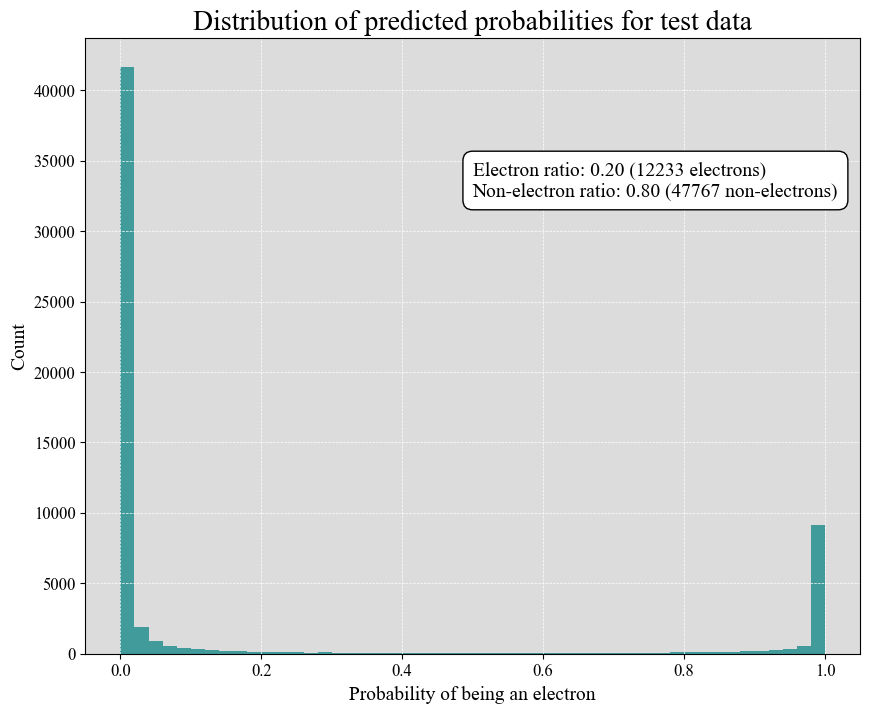

In [37]:
# Testing the model on the test data
reshap_test_data = test_data[sort_variables[-25:]].copy()
print(reshap_test_data.shape)

# Getting the predictions
y_test_pred = model.predict(reshap_test_data)
y_test_binary_score = np.where(y_test_pred > 0.5, 1, 0)

electron_ratio = np.sum(y_test_binary_score) / len(y_test_binary_score)
non_electron_ratio = 1-electron_ratio


fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(y_test_pred, bins=50, color="teal", alpha=0.7)
ax.set_xlabel("Probability of being an electron")
ax.set_ylabel("Count")
ax.set_title("Distribution of predicted probabilities for test data")
ax.text(
    0.5, 0.8, f"Electron ratio: {electron_ratio:.2f} ({sum(y_test_binary_score)} electrons) \nNon-electron ratio: {non_electron_ratio:.2f} ({len(y_test_binary_score) - sum(y_test_binary_score)} non-electrons)",
    transform=ax.transAxes,
    fontsize=14,
    verticalalignment="top",
    bbox=dict(boxstyle="round,pad=0.5", edgecolor="black", facecolor="white"),
)



### Neural networks using PyTorch

In [38]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler


X_train, X_valid, y_train, y_valid = train_test_split(reshap_data, truth_data, test_size=0.2, random_state=42)
reshap_test_data = test_data[sort_variables[-25:]].copy()


# Standardizing the data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_valid_scaled = pd.DataFrame(scaler.fit_transform(X_valid), columns=X_valid.columns)
X_test_scaled = pd.DataFrame(scaler.fit_transform(test_data[sort_variables[-25:]]), columns=test_data[sort_variables[-25:]].columns)


In [39]:

# Define the neural network model
import torch.nn as nn 
import torch.nn.functional as F

class ClassificationDataset(Dataset):
    def __init__(self, X, y=None):
        
        if isinstance(X, pd.Series):
            X = X.values.reshape(-1, 1)  # Make it 2D
        if isinstance(X, pd.DataFrame):
            X = X.values
        X = np.asarray(X, dtype=np.float32)
        self.X = torch.from_numpy(X)
        if y is not None:
            if isinstance(y, pd.Series) or isinstance(y, pd.DataFrame):
                y = y.values
            y = np.asarray(y, dtype=np.float32).reshape(-1, 1)  # Make it 2D
            self.y = torch.from_numpy(y)
        else:
            self.y = None

    def __len__(self):
        value = int(len(self.X))
        return value
    
    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        else:
            return self.X[idx]

class SimpleClassifier(nn.Module):
    def __init__(self, input_size):
        super(SimpleClassifier, self).__init__()   
        self.fc1 = nn.Linear(input_size, 64)        # Hidden layer 1
        self.dropout = nn.Dropout(0.2)              # Dropout layer
        self.output = nn.Linear(64, 1)              # Results in binary classification

    def forward(self, x):
        x = F.relu(self.fc1(x))                     # ReLU activation for hidden layer 1
        x = self.dropout(x)                         # Apply dropout
        x = torch.sigmoid(self.output(x))           # Sigmoid activation for binary classification (output between 0 and 1)
        return x


# Setting op training and evaluation functions
def train_torch_NN(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for x_batch, y_batch in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x_batch.size(0)
    return running_loss / len(loader.dataset)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_torch_NN(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            running_loss += loss.item() * x_batch.size(0)
            all_preds.append(outputs.cpu())
            all_targets.append(y_batch.cpu())

    preds = torch.cat(all_preds).numpy()
    targets = torch.cat(all_targets).numpy()

    return running_loss / len(loader.dataset), preds, targets


In [40]:
# Creating PyTorch datasets
train_data_torch = ClassificationDataset(X_train_scaled, y_train)
valid_data_torch = ClassificationDataset(X_valid_scaled, y_valid)
test_data_torch = ClassificationDataset(X_test_scaled)


# Creating DataLoader objects
train_loader = DataLoader(train_data_torch, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_data_torch, batch_size=64, shuffle=False, num_workers=0, pin_memory=False)
test_loader = DataLoader(test_data_torch, batch_size=64, shuffle=False, num_workers=0, pin_memory=False)





In [ ]:
# Initialize the model

torch_model = SimpleClassifier(input_size=X_train_scaled.shape[1]).to(device)

# Define the loss function and optimizer
criterion = nn.BCELoss()                       # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(torch_model.parameters(), lr=0.001)  # Adam optimizer with learning rate of 0.001


# Running the training
n_epochs = 100
train_losses = []
valid_losses = []
auc_list = []
tpr_list = []
fpr_list = []

# Early stopping parameter setup
best_val_loss = float("inf")
patience = 5 
counter = 0
epoch_reached = 1
for epoch in range(n_epochs):
    train_loss = train_torch_NN(torch_model, train_loader, criterion, optimizer, device)
    valid_loss, valid_preds, valid_targets = evaluate_torch_NN(torch_model, valid_loader, criterion)

    # Early stopping
    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        best_model_state = torch_model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping! Counter reached: {counter}")
            torch_model.load_state_dict(best_model_state)
            break

    fpr, tpr, _ = roc_curve(valid_targets, valid_preds)
    tpr_list.append(tpr)
    fpr_list.append(fpr)
    roc_score = auc(fpr, tpr)

    valid_pred_binary = np.where(valid_preds > 0.5, 1, 0)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    auc_list.append(roc_score)
    epoch_reached += 1
    
    
    if epoch % 10 == 0 or epoch == n_epochs - 1:
        print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, ROC-AUC. : {roc_score:.4f}")


I got to here 2
Epoch 1/100, Train Loss: 0.1651, Valid Loss: 0.1284, ROC-AUC. : 0.9813
I got to here 2
I got to here 2
I got to here 2
I got to here 2
I got to here 2
I got to here 2
I got to here 2
I got to here 2
I got to here 2
I got to here 2
Epoch 11/100, Train Loss: 0.1074, Valid Loss: 0.1106, ROC-AUC. : 0.9863
I got to here 2
I got to here 2
I got to here 2
I got to here 2
I got to here 2
I got to here 2
I got to here 2
Early stopping! Counter reached: 5


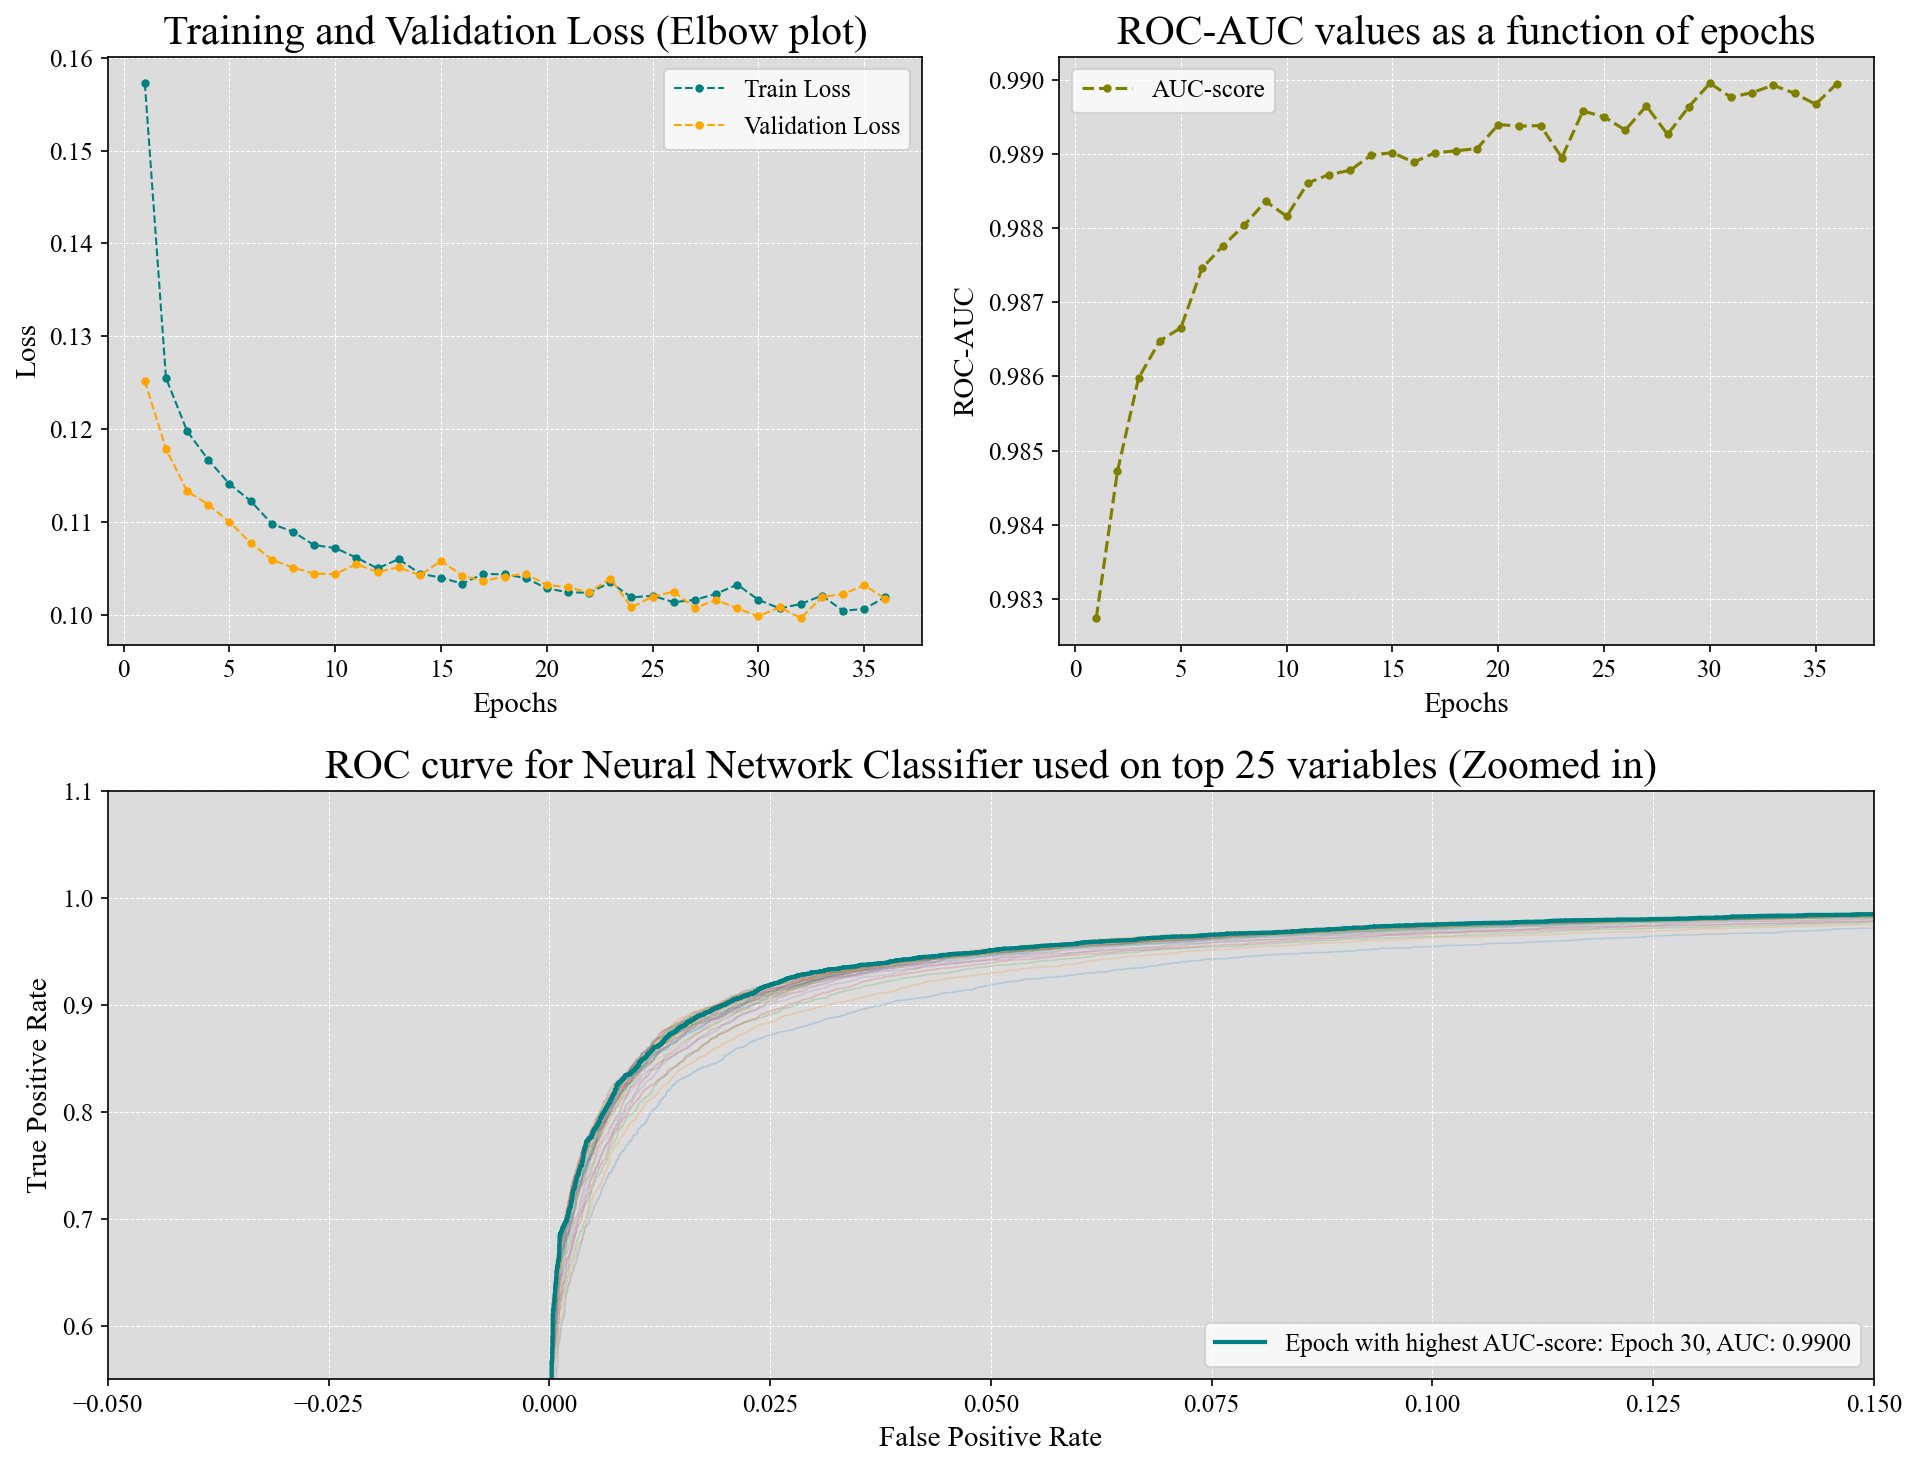

In [ ]:
import matplotlib.gridspec as gridspec


gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])
fig = plt.figure(figsize=(13, 10), dpi=150, facecolor="white")
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,:])


ax1.plot(range(1, epoch_reached), train_losses, label="Train Loss", color="teal", marker='.', ls='--', linewidth=1)
ax1.plot(range(1, epoch_reached), valid_losses, label="Validation Loss", color="orange", marker='.', ls='--', linewidth=1)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training and Validation Loss (Elbow plot)")
ax1.legend()

ax2.plot(range(1, epoch_reached), auc_list, label="AUC-score", color="olive", marker='.', ls='--')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("ROC-AUC")
ax2.set_title("ROC-AUC values as a function of epochs")
ax2.legend()

for i in range(len(tpr_list)):
    ax3.plot(fpr_list[i], tpr_list[i], alpha=0.2, linewidth=0.7)
max_idx= np.argmax(auc_list)
ax3.plot(fpr_list[max_idx], tpr_list[max_idx], label=f"Epoch with highest AUC-score: Epoch {max_idx+1}, AUC: {auc_list[max_idx]:.4f}", color="teal", linewidth=2)
ax3.plot([0, 1], [0, 1], color="k", linestyle="-.", linewidth=0.5)
ax3.set(xlim=(-0.05, 0.15), ylim=(0.55, 1.1))
ax3.legend(loc="lower right", fontsize=12)
ax3.set_xlabel("False Positive Rate")
ax3.set_ylabel("True Positive Rate")
ax3.set_title("ROC curve for Neural Network Classifier used on top 25 variables (Zoomed in)")


# Optional: remove background grid behind axes if set globally
fig.patch.set_facecolor('white')  # Figure background
fig.patch.set_alpha(1.0)

plt.tight_layout()

### Using torch model to predict test-data

In [ ]:
# Predictin the test data using the torch model



